In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import japanize_matplotlib

# preparation

In [3]:
DATA_DIR = "./data/"

In [4]:
dirs = sorted(os.listdir(DATA_DIR))
dirs = [i for i in dirs if "check" not in i][:-3]
print(dirs)

['2022-03-25', '2022-03-26', '2022-03-27', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01', '2022-05-03']


In [5]:
for id_, folder in enumerate(dirs):
    files = sorted(os.listdir(DATA_DIR + folder))
    files = [i for i in files if ".csv" in i]
    batter = pd.read_csv(DATA_DIR + folder + "/" + files[0])
    detail = pd.read_csv(DATA_DIR + folder + "/" + files[1])
    pitcher = pd.read_csv(DATA_DIR + folder + "/" + files[2])
    score = pd.read_csv(DATA_DIR + folder + "/" + files[3])

    if id_ == 0:
        print(files)
        pitcher_df = pitcher.copy()
        score_df = score.copy()
        batter_df = batter.copy()
        
        detail_df = detail.copy()
    else:
        pitcher_df = pd.concat([pitcher_df, pitcher], axis= 0)
        score_df = pd.concat([score_df, score], axis= 0)
        batter_df = pd.concat([batter_df, batter], axis= 0)

        detail_df = pd.concat([detail_df, detail], axis= 0)

pitcher_df = pitcher_df.reset_index(drop=True)
score_df = score_df.reset_index(drop=True)
batter_df = batter_df.reset_index(drop=True)
detail_df = detail_df.reset_index(drop=True)

['batter.csv', 'detail.csv', 'pitcher.csv', 'score.csv']


# analysis

In [6]:
# 自身のデータと対戦相手のデータを総合で突き合わせる
def check_merged_data(df, col, op, include_opponent=True):
    if op == "sum":
        op_col = "合計"
    else:
        op_col = ""
        
    data = df.groupby(["自"]).agg({"日付": "nunique"}).reset_index(drop=False)
    data.columns = ["チーム", "試合数"]
    get = df.groupby(["自"]).agg({col: op}).reset_index(drop=False)
    get.columns = ["チーム", "自"+str(col)+"_"+op_col]
    
    data = pd.merge(data, get, on="チーム", how="left")
    last_column = data.columns[-1]
    data[last_column.split("_")[0]+"_平均"] = data[last_column] / data["試合数"]
    data[last_column.split("_")[0]+"_平均"] = data[last_column.split("_")[0]+"_平均"].round(2)

    if include_opponent:
        give = df.groupby(["相"]).agg({col: op}).reset_index(drop=False)
        give.columns = ["チーム", "相手"+str(col)+"_"+op_col]
        data = pd.merge(data, give, on="チーム", how="left")
        last_column = data.columns[-1]
        data[last_column.split("_")[0]+"_平均"] = data[last_column] / data["試合数"]
        data[last_column.split("_")[0]+"_平均"] = data[last_column.split("_")[0]+"_平均"].round(2)
    
    return data.sort_values("チーム").reset_index(drop=True)

In [7]:
def make_plot(df):
    cmap_keyword = "jet"
    cmap = plt.get_cmap(cmap_keyword)
    labels = df["チーム"]
    n_labels = 12
    columns = [i for i in df.columns if "平均" in i]

    fig, ax = plt.subplots(figsize=(8,6))
    x_ = columns[0]
    y_ = columns[1]
    for idx, label in enumerate(labels):
        c = cmap(idx/(n_labels-3))
        ax.plot(df.iloc[idx][x_], df.iloc[idx][y_], 'bo', color=c, label=label)
        plt.annotate(label, (df[x_].values[idx], df[y_].values[idx]))
        
    mini = max(min(df[x_].min(), df[y_].min()),0)
    maxi = max(df[x_].max(), df[y_].max()) + 0.5
    x = np.linspace(mini, maxi, 100)
    ax.plot(x, x, color = "black", linestyle="dotted")
    
    plt.xlabel(x_)
    plt.ylabel(y_)
    plt.xlim(mini, maxi)
    plt.ylim(mini, maxi)
    plt.show()

In [8]:
# 勝率の推移を時系列で確認
def make_weekly_rank_plot(teams):
    wl_table = score_df[score_df["チーム"].isin(teams)].groupby(["チーム", "week"])["result"].value_counts().reset_index(name="count")
    wl_table = wl_table.pivot(index=['week', 'チーム'], columns='result', values='count').fillna(0).astype(int)
    wl_table = wl_table.reindex(reversed(sorted(wl_table.columns)), axis=1)

    cons_columns = ["W", "L", "D"] if "D" in wl_table.columns else  ["W", "L"]
    wl_table["percentage"] = wl_table["W"] / wl_table[cons_columns].sum(axis=1)
    wl_table = wl_table.sort_values(["week", "percentage"], ascending=False)
    wl_table["rank"] = wl_table.groupby("week")["percentage"].rank(ascending=False, method='min').astype(int)
    wl_table = wl_table.reorder_levels(['チーム','week']).sort_index()
    display(wl_table)

    x = score_df.week.unique()

    color = ["b", "g", "r", "c", "m", "y"]

    plt.figure(figsize=(10,6))
    for ind, team in enumerate(teams):
        plt.plot(x, wl_table.loc[team,:]["percentage"].values, label=team, color=color[ind])
    #plt.gca().invert_yaxis()
    plt.xticks(x, x)
    plt.legend(bbox_to_anchor=(1, 1), loc="best")

## win-lose

In [9]:
pacific = ['ソフトバンク',  '楽天', '西武',  'オリックス', 'ロッテ', '日本ハム']
central = ['広島', '巨人', 'DeNA', 'ヤクルト',  '中日',  '阪神']

result     W  L  D  percentage  rank
チーム  week                           
DeNA 0     3  3  0    0.500000     3
     1     2  2  0    0.500000     3
     2     0  2  0    0.000000     5
     3     4  2  0    0.666667     1
     4     1  5  0    0.166667     6
     5     0  2  0    0.000000     5
ヤクルト 0     3  3  0    0.500000     3
     1     2  3  0    0.400000     4
     2     3  2  0    0.600000     2
     3     3  2  0    0.600000     3
     4     3  2  0    0.600000     3
     5     2  0  0    1.000000     1
中日   0     1  5  0    0.166667     5
     1     5  1  0    0.833333     1
     2     3  0  0    1.000000     1
     3     2  2  0    0.500000     4
     4     1  4  0    0.200000     5
     5     3  1  0    0.750000     2
巨人   0     5  1  0    0.833333     2
     1     4  2  0    0.666667     2
     2     3  2  0    0.600000     2
     3     4  2  0    0.666667     1
     4     4  2  0    0.666667     2
     5     0  4  0    0.000000     5
広島   0     6  0  0    1.000000     1
     1     2  4  0    0.333333     5
     2     3  1  1    0.600000     2
     3     1  4  0    0.200000     6
     4     3  2  0    0.600000     3
     5     2  2  0    0.500000     4
阪神   0     0  6  0    0.000000     6
     1     1  4  0    0.200000     6
     2     0  5  1    0.000000     5
     3     2  4  0    0.333333     5
     4     4  1  0    0.800000     1
     5     3  1  0    0.750000     2

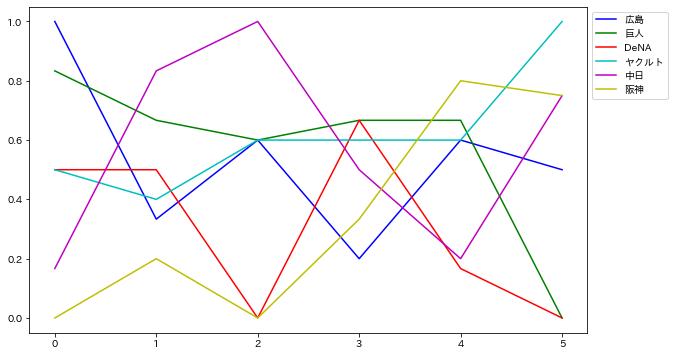

In [10]:
make_weekly_rank_plot(central)

result       W  L  D  percentage  rank
チーム    week                           
オリックス  0     1  5  0    0.166667     5
       1     4  2  0    0.666667     3
       2     1  2  0    0.333333     6
       3     4  2  0    0.666667     2
       4     3  3  0    0.500000     2
       5     2  2  0    0.500000     2
ソフトバンク 0     6  0  0    1.000000     1
       1     3  1  0    0.750000     2
       2     2  2  1    0.400000     3
       3     1  4  0    0.200000     5
       4     3  3  0    0.500000     2
       5     1  2  0    0.333333     4
ロッテ    0     1  4  0    0.200000     4
       1     4  1  0    0.800000     1
       2     3  2  0    0.600000     2
       3     0  4  0    0.000000     6
       4     2  3  1    0.333333     5
       5     1  2  0    0.333333     4
日本ハム   0     1  5  0    0.166667     5
       1     1  4  0    0.200000     5
       2     2  3  0    0.400000     3
       3     3  2  0    0.600000     3
       4     2  4  0    0.333333     5
       5     1  2  0    0.333333     4
楽天     0     4  1  0    0.800000     2
       1     2  1  0    0.666667     3
       2     2  1  0    0.666667     1
       3     4  1  0    0.800000     1
       4     3  2  1    0.500000     2
       5     3  0  0    1.000000     1
西武     0     4  2  0    0.666667     3
       1     0  5  0    0.000000     6
       2     2  2  1    0.400000     3
       3     3  2  0    0.600000     3
       4     4  2  0    0.666667     1
       5     2  2  0    0.500000     2

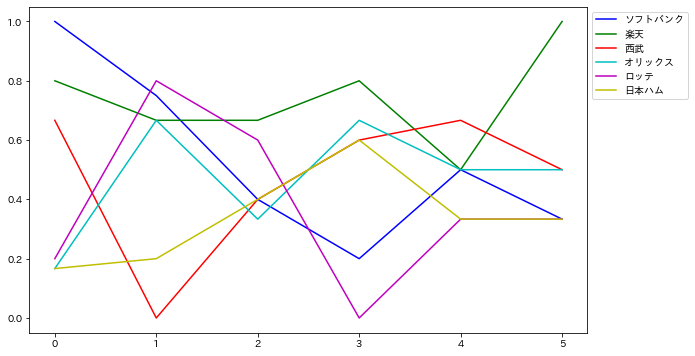

In [11]:
make_weekly_rank_plot(pacific)

## batter_df

In [12]:
batter_df.head()

,位置,名,打率,打数,得点,安打,打点,三振,四球,死球,犠打,盗塁,失策,本塁打,自,相,H/V,日付,ID,week
0,中,塩見 泰隆,.400,5,1,2,1,2,0,0,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0
1,左,青木 宣親,.000,4,0,0,0,0,0,0,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0
2,投,坂本 光士郎,-,0,0,0,0,0,0,0,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0
3,指,川端 慎吾,.000,1,0,0,0,0,0,0,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0
4,投,梅野 雄吾,-,0,0,0,0,0,0,0,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0


### 打数

,チーム,試合数,自打数_合計,自打数_平均,相手打数_合計,相手打数_平均
0,ヤクルト,28,923,32.96,947,33.82
1,DeNA,26,870,33.46,867,33.35
2,オリックス,31,982,31.68,1030,33.23
3,ソフトバンク,29,974,33.59,937,32.31
4,ロッテ,28,928,33.14,927,33.11
5,中日,28,942,33.64,931,33.25
6,巨人,33,1094,33.15,1080,32.73
7,広島,31,1045,33.71,1049,33.84
8,日本ハム,30,1000,33.33,990,33.00
9,楽天,25,820,32.80,831,33.24


|    | チーム       |   試合数 |   自打数_合計 |   自打数_平均 |
|---:|:-------------|---------:|--------------:|--------------:|
|  0 | ヤクルト     |       28 |           923 |         32.96 |
|  1 | DeNA         |       26 |           870 |         33.46 |
|  2 | オリックス   |       31 |           982 |         31.68 |
|  3 | ソフトバンク |       29 |           974 |         33.59 |
|  4 | ロッテ       |       28 |           928 |         33.14 |
|  5 | 中日         |       28 |           942 |         33.64 |
|  6 | 巨人         |       33 |          1094 |         33.15 |
|  7 | 広島         |       31 |          1045 |         33.71 |
|  8 | 日本ハム     |       30 |          1000 |         33.33 |
|  9 | 楽天         |       25 |           820 |         32.8  |
| 10 | 西武         |       31 |           982 |         31.68 |
| 11 | 阪神         |       32 |          1055 |         32.97 |


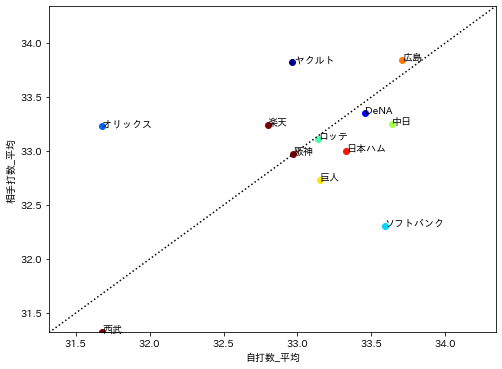

In [13]:
merged_df = check_merged_data(batter_df, "打数", "sum", True)

display(merged_df)
print(merged_df.iloc[:,:4].to_markdown())

make_plot(merged_df)

### 安打

,チーム,試合数,自安打_合計,自安打_平均,相手安打_合計,相手安打_平均
0,ヤクルト,28,208,7.43,234,8.36
1,DeNA,26,209,8.04,223,8.58
2,オリックス,31,205,6.61,246,7.94
3,ソフトバンク,29,252,8.69,201,6.93
4,ロッテ,28,198,7.07,200,7.14
5,中日,28,240,8.57,219,7.82
6,巨人,33,273,8.27,253,7.67
7,広島,31,266,8.58,257,8.29
8,日本ハム,30,233,7.77,249,8.30
9,楽天,25,194,7.76,190,7.60


|    | チーム       |   試合数 |   自安打_合計 |   自安打_平均 |
|---:|:-------------|---------:|--------------:|--------------:|
|  0 | ヤクルト     |       28 |           208 |          7.43 |
|  1 | DeNA         |       26 |           209 |          8.04 |
|  2 | オリックス   |       31 |           205 |          6.61 |
|  3 | ソフトバンク |       29 |           252 |          8.69 |
|  4 | ロッテ       |       28 |           198 |          7.07 |
|  5 | 中日         |       28 |           240 |          8.57 |
|  6 | 巨人         |       33 |           273 |          8.27 |
|  7 | 広島         |       31 |           266 |          8.58 |
|  8 | 日本ハム     |       30 |           233 |          7.77 |
|  9 | 楽天         |       25 |           194 |          7.76 |
| 10 | 西武         |       31 |           218 |          7.03 |
| 11 | 阪神         |       32 |           245 |          7.66 |


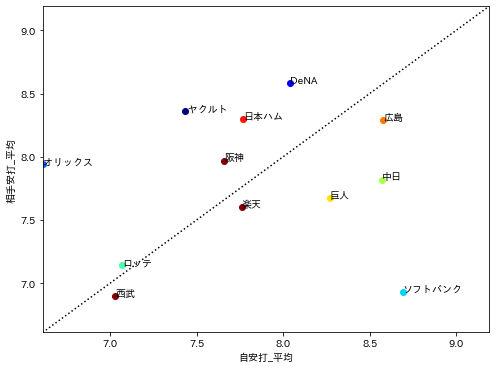

In [14]:
merged_df = check_merged_data(batter_df, "安打", "sum", True)

display(merged_df)
print(merged_df.iloc[:,:4].to_markdown())

make_plot(merged_df)

### 得点

,チーム,試合数,自得点_合計,自得点_平均,相手得点_合計,相手得点_平均
0,ヤクルト,28,104,3.71,105,3.75
1,DeNA,26,88,3.38,119,4.58
2,オリックス,31,77,2.48,99,3.19
3,ソフトバンク,29,114,3.93,101,3.48
4,ロッテ,28,82,2.93,79,2.82
5,中日,28,101,3.61,94,3.36
6,巨人,33,140,4.24,131,3.97
7,広島,31,133,4.29,103,3.32
8,日本ハム,30,99,3.30,123,4.10
9,楽天,25,103,4.12,69,2.76


|    | チーム       |   試合数 |   自安打_合計 |   自安打_平均 |
|---:|:-------------|---------:|--------------:|--------------:|
|  0 | ヤクルト     |       28 |           208 |          7.43 |
|  1 | DeNA         |       26 |           209 |          8.04 |
|  2 | オリックス   |       31 |           205 |          6.61 |
|  3 | ソフトバンク |       29 |           252 |          8.69 |
|  4 | ロッテ       |       28 |           198 |          7.07 |
|  5 | 中日         |       28 |           240 |          8.57 |
|  6 | 巨人         |       33 |           273 |          8.27 |
|  7 | 広島         |       31 |           266 |          8.58 |
|  8 | 日本ハム     |       30 |           233 |          7.77 |
|  9 | 楽天         |       25 |           194 |          7.76 |
| 10 | 西武         |       31 |           218 |          7.03 |
| 11 | 阪神         |       32 |           245 |          7.66 |


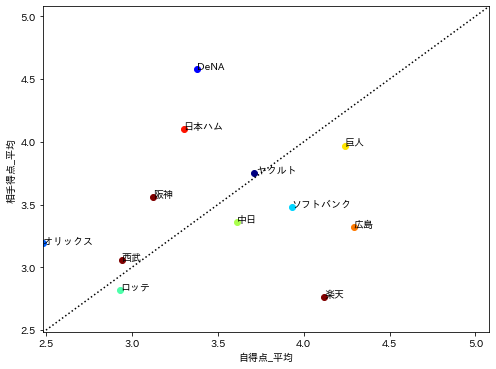

In [15]:
merged_score = check_merged_data(batter_df, "得点", "sum")

display(merged_score)
print(merged_df.iloc[:,:4].to_markdown())

make_plot(merged_score)

### 出場選手数

,チーム,試合数,自名_,自名_平均,相手名_,相手名_平均
0,ヤクルト,28,449,16.04,442,15.79
1,DeNA,26,431,16.58,425,16.35
2,オリックス,31,357,11.52,370,11.94
3,ソフトバンク,29,363,12.52,342,11.79
4,ロッテ,28,351,12.54,334,11.93
5,中日,28,452,16.14,443,15.82
6,巨人,33,549,16.64,527,15.97
7,広島,31,479,15.45,513,16.55
8,日本ハム,30,363,12.10,356,11.87
9,楽天,25,284,11.36,302,12.08


|    | チーム       |   試合数 |   自名_ |   自名_平均 |   相手名_ |   相手名_平均 |
|---:|:-------------|---------:|--------:|------------:|----------:|--------------:|
|  2 | オリックス   |       31 |     357 |       11.52 |       370 |         11.94 |
|  3 | ソフトバンク |       29 |     363 |       12.52 |       342 |         11.79 |
|  4 | ロッテ       |       28 |     351 |       12.54 |       334 |         11.93 |
|  8 | 日本ハム     |       30 |     363 |       12.1  |       356 |         11.87 |
|  9 | 楽天         |       25 |     284 |       11.36 |       302 |         12.08 |
| 10 | 西武         |       31 |     342 |       11.03 |       356 |         11.48 |
 
|    | チーム   |   試合数 |   自名_ |   自名_平均 |   相手名_ |   相手名_平均 |
|---:|:---------|---------:|--------:|------------:|----------:|--------------:|
|  0 | ヤクルト |       28 |     449 |       16.04 |       442 |         15.79 |
|  1 | DeNA     |       26 |     431 |       16.58 |       425 |         16.35 |
|  5 | 中日     |       28 |     452 |       16.14 |       443

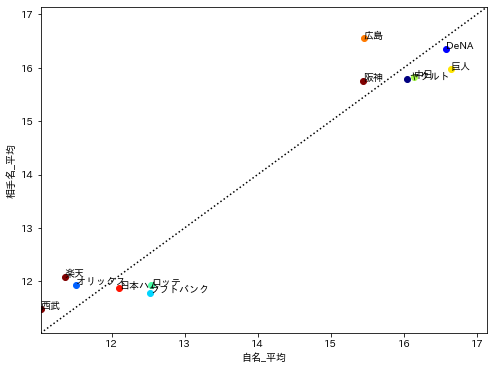

In [98]:
merged_df = check_merged_data(batter_df, "名", "count")

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].to_markdown())

make_plot(merged_df)

### 得点

In [17]:
tokuten = batter_df.groupby("名").agg({"得点": "sum", "自": "unique"}).sort_values("得点", ascending=False).reset_index(drop=False)
tokuten["自"] = tokuten["自"].apply(lambda x: x[0])

print(tokuten[tokuten["自"].isin(pacific)].head(10).to_markdown())
print(" ")
print(tokuten[~tokuten["自"].isin(pacific)].head(10).to_markdown())

|    | 名           |   得点 | 自           |
|---:|:-------------|-------:|:-------------|
|  0 | 西川 遥輝    |     25 | 楽天         |
|  3 | 三森 大貴    |     19 | ソフトバンク |
| 11 | 福田 周平    |     15 | オリックス   |
| 15 | 野村 勇      |     14 | ソフトバンク |
| 18 | オグレディ   |     13 | 西武         |
| 19 | 浅村 栄斗    |     13 | 楽天         |
| 20 | アルカンタラ |     13 | 日本ハム     |
| 22 | 松本 剛      |     12 | 日本ハム     |
| 29 | 上林 誠知    |     11 | ソフトバンク |
| 30 | 山川 穂高    |     11 | 西武         |
 
|    | 名        |   得点 | 自       |
|---:|:----------|-------:|:---------|
|  1 | 西川 龍馬 |     22 | 広島     |
|  2 | 丸 佳浩   |     22 | 巨人     |
|  4 | 村上 宗隆 |     18 | ヤクルト |
|  5 | 佐藤 輝明 |     18 | 阪神     |
|  6 | 坂倉 将吾 |     18 | 広島     |
|  7 | 吉川 尚輝 |     17 | 巨人     |
|  8 | 岡本 和真 |     17 | 巨人     |
|  9 | ポランコ  |     15 | 巨人     |
| 10 | 阿部 寿樹 |     15 | 中日     |
| 12 | 塩見 泰隆 |     15 | ヤクルト |


### 三振数の少なさ

In [108]:
tokuten = batter_df.groupby("名").agg({"三振": "sum", "打数": "sum", "自": "unique"}).reset_index(drop=False)
tokuten["自"] = tokuten["自"].apply(lambda x: x[0])
tokuten = pd.merge(tokuten, merged_df[["チーム", "試合数"]], left_on = "自", right_on = "チーム")
tokuten["規定"] = tokuten["打数"] >  tokuten["試合数"] * 3.1
tokuten = tokuten[tokuten["規定"]].reset_index(drop=True).sort_values("三振", ascending=True)

print(tokuten[tokuten["自"].isin(pacific)].head(10).to_markdown())
print(" ")
print(tokuten[~tokuten["自"].isin(pacific)].head(10).to_markdown())

|    | 名          |   三振 |   打数 | 自           | チーム       |   試合数 | 規定   |
|---:|:------------|-------:|-------:|:-------------|:-------------|---------:|:-------|
| 41 | 吉田 正尚   |      9 |    102 | オリックス   | オリックス   |       31 | True   |
| 42 | 福田 周平   |     10 |    104 | オリックス   | オリックス   |       31 | True   |
| 32 | 今宮 健太   |     11 |     90 | ソフトバンク | ソフトバンク |       29 | True   |
| 31 | 中村 晃     |     13 |     94 | ソフトバンク | ソフトバンク |       29 | True   |
| 34 | 島内 宏明   |     14 |     98 | 楽天         | 楽天         |       25 | True   |
| 22 | 源田 壮亮   |     15 |    104 | 西武         | 西武         |       31 | True   |
| 43 | 紅林 弘太郎 |     15 |    111 | オリックス   | オリックス   |       31 | True   |
|  6 | 近藤 健介   |     15 |    102 | 日本ハム     | 日本ハム     |       30 | True   |
| 29 | グラシアル  |     17 |    106 | ソフトバンク | ソフトバンク |       29 | True   |
| 18 | 佐藤 都志也 |     18 |     87 | ロッテ       | ロッテ       |       28 | True   |
 
|    | 名        |   三振 |   打数 | 自       | チーム   |   試合数 | 規定   |
|---:|:--

### チーム別打率

In [20]:
daritu = batter_df.groupby(["自"]).agg({"打数": "sum", "安打": "sum"}).reset_index()
daritu["打率"] = daritu["安打"] / daritu["打数"]
display(daritu)

print(daritu[daritu["自"].isin(pacific)].iloc[:,:4].sort_values("打率", ascending=False).to_markdown())
print(" ")
print(daritu[~daritu["自"].isin(pacific)].iloc[:,:4].sort_values("打率", ascending=False).to_markdown())

,自,打数,安打,打率
0,ヤクルト,923,208,0.225352
1,DeNA,870,209,0.240230
2,オリックス,982,205,0.208758
3,ソフトバンク,974,252,0.258727
4,ロッテ,928,198,0.213362
5,中日,942,240,0.254777
6,巨人,1094,273,0.249543
7,広島,1045,266,0.254545
8,日本ハム,1000,233,0.233000
9,楽天,820,194,0.236585


|    | 自           |   打数 |   安打 |     打率 |
|---:|:-------------|-------:|-------:|---------:|
|  3 | ソフトバンク |    974 |    252 | 0.258727 |
|  9 | 楽天         |    820 |    194 | 0.236585 |
|  8 | 日本ハム     |   1000 |    233 | 0.233    |
| 10 | 西武         |    982 |    218 | 0.221996 |
|  4 | ロッテ       |    928 |    198 | 0.213362 |
|  2 | オリックス   |    982 |    205 | 0.208758 |
 
|    | 自       |   打数 |   安打 |     打率 |
|---:|:---------|-------:|-------:|---------:|
|  5 | 中日     |    942 |    240 | 0.254777 |
|  7 | 広島     |   1045 |    266 | 0.254545 |
|  6 | 巨人     |   1094 |    273 | 0.249543 |
|  1 | DeNA     |    870 |    209 | 0.24023  |
| 11 | 阪神     |   1055 |    245 | 0.232227 |
|  0 | ヤクルト |    923 |    208 | 0.225352 |


### 打順別打率

In [21]:
# 打順を紐付けしたい

### イニング別打率

### ポジション別打率

### 対戦チーム別打率

<AxesSubplot:xlabel='相', ylabel='自'>

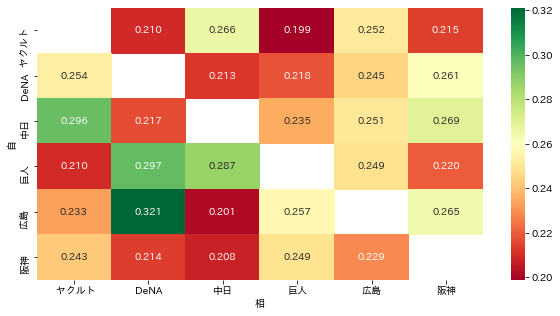

In [45]:
daritsu_by_pos = batter_df.groupby(["自", "相"]).agg({"打数": "sum", "安打": "sum"}).reset_index()
daritsu_by_pos["打率"] = daritsu_by_pos["安打"] / daritsu_by_pos["打数"]

tmp = daritsu_by_pos[~daritsu_by_pos["自"].isin(pacific)][["自", "相", "打率"]]

plt.figure(figsize=(10,5))
sns.heatmap(tmp.pivot("自", "相", "打率"), annot=True, fmt='.3f', cmap='RdYlGn')

<AxesSubplot:xlabel='相', ylabel='自'>

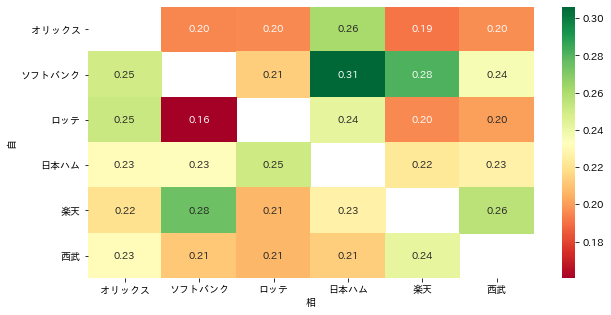

In [46]:
daritsu_by_pos = batter_df.groupby(["自", "相"]).agg({"打数": "sum", "安打": "sum"}).reset_index()
daritsu_by_pos["打率"] = daritsu_by_pos["安打"] / daritsu_by_pos["打数"]

tmp = daritsu_by_pos[daritsu_by_pos["自"].isin(pacific)][["自", "相", "打率"]]

plt.figure(figsize=(10,5))
sns.heatmap(tmp.pivot("自", "相", "打率"), annot=True, fmt='.2f', cmap='RdYlGn')

### 先発、中継ぎ別打率

<AxesSubplot:xlabel='位', ylabel='相'>

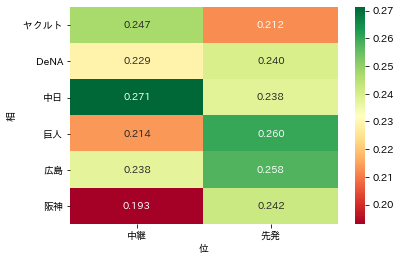

In [80]:
tmp = pitcher_df.groupby(["相", "位"]).agg({"被安打": "sum", "投球回": "sum"}).reset_index()
tmp["打数"] = tmp["投球回"].astype(int) * 3 + (tmp["投球回"] * 10) % 10 + tmp["被安打"]
tmp["打率"] = tmp["被安打"] / tmp["打数"]

tmp1 = tmp[~tmp["相"].isin(pacific)][["相", "位", "打率"]]
tmp2 = tmp[tmp["相"].isin(pacific)][["相", "位", "打率"]]

display(sns.heatmap(tmp1.pivot("相", "位", "打率"), annot=True, fmt='.3f', cmap='RdYlGn'))

<AxesSubplot:xlabel='位', ylabel='相'>

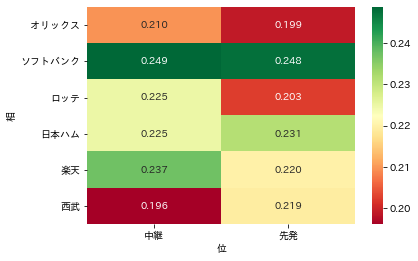

In [81]:
display(sns.heatmap(tmp2.pivot("相", "位", "打率"), annot=True, fmt='.3f', cmap='RdYlGn'))

## pitcher

In [17]:
pitcher_df.head()

,位,選手名,防御率,投球回,投球数,打者,被安打,被本塁打,奪三振,与四球,与死球,ボーク,失点,自責点,自,相,H/V,日付,ID,week
0,先発,小川 泰弘,12,3.0,80,18,11,0,2,0,0,0,4,4,ヤクルト,阪神,V,2022-03-25,0,0
1,中継,大下 佑馬,3,3.0,45,13,3,1,5,0,0,0,4,1,ヤクルト,阪神,V,2022-03-25,0,0
2,中継,坂本 光士郎,0,1.0,26,4,0,0,1,1,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0
3,中継,梅野 雄吾,0,1.0,11,3,0,0,0,0,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0
4,中継,マクガフ,0,1.0,19,5,1,0,0,1,0,0,0,0,ヤクルト,阪神,V,2022-03-25,0,0


### 防御率

In [18]:
era = pitcher_df.groupby(["自", "位"]).agg({"投球回": "sum", "自責点": "sum"}).reset_index()
era["自"] = era["自"].apply(lambda x: 'ヤクルト' if 'ヤクルト' in x else x)
era = era[era["自"].isin(central)]
era["防御率"] = (era["自責点"] / era["投球回"]) * 9
print(era.sort_values(["位", "防御率"]).reset_index(drop=True).to_markdown())

|    | 自       | 位   |   投球回 |   自責点 |   防御率 |
|---:|:---------|:-----|---------:|---------:|---------:|
|  0 | ヤクルト | 中継 |     88.8 |       27 |  2.73649 |
|  1 | 中日     | 中継 |     74.8 |       25 |  3.00802 |
|  2 | 巨人     | 中継 |     81   |       34 |  3.77778 |
|  3 | DeNA     | 中継 |     78.6 |       35 |  4.00763 |
|  4 | 阪神     | 中継 |     80.8 |       37 |  4.12129 |
|  5 | 広島     | 中継 |     68.6 |       37 |  4.85423 |
|  6 | 広島     | 先発 |    183.8 |       54 |  2.64418 |
|  7 | 巨人     | 先発 |    179.3 |       62 |  3.1121  |
|  8 | 阪神     | 先発 |    170.2 |       67 |  3.54289 |
|  9 | 中日     | 先発 |    152.6 |       61 |  3.59764 |
| 10 | ヤクルト | 先発 |    145.6 |       62 |  3.83242 |
| 11 | DeNA     | 先発 |    135.3 |       66 |  4.39024 |


In [19]:
era = pitcher_df.groupby(["自", "位"]).agg({"投球回": "sum", "自責点": "sum"}).reset_index()
era = era[era["自"].isin(pacific)]
era["防御率"] = (era["自責点"] / era["投球回"]) * 9
print(era.sort_values(["位", "防御率"]).reset_index(drop=True).to_markdown())

|    | 自           | 位   |   投球回 |   自責点 |   防御率 |
|---:|:-------------|:-----|---------:|---------:|---------:|
|  0 | 西武         | 中継 |     89.4 |       22 |  2.21477 |
|  1 | オリックス   | 中継 |     77.6 |       23 |  2.66753 |
|  2 | ソフトバンク | 中継 |     89.3 |       28 |  2.82195 |
|  3 | 楽天         | 中継 |     66   |       22 |  3       |
|  4 | ロッテ       | 中継 |     63.1 |       23 |  3.28051 |
|  5 | 日本ハム     | 中継 |     97.3 |       45 |  4.16238 |
|  6 | ロッテ       | 先発 |    170.6 |       28 |  1.47714 |
|  7 | 楽天         | 先発 |    142.2 |       42 |  2.65823 |
|  8 | オリックス   | 先発 |    173.3 |       57 |  2.96018 |
|  9 | 西武         | 先発 |    157.2 |       53 |  3.03435 |
| 10 | ソフトバンク | 先発 |    146.2 |       54 |  3.32421 |
| 11 | 日本ハム     | 先発 |    140   |       68 |  4.37143 |


### 登板投手数

,チーム,試合数,自登板投手数,自投球数_平均,相手登板投手数,相手投球数_平均
0,ヤクルト,27,117,4.33,109,4.04
1,DeNA,25,108,4.32,104,4.16
2,オリックス,29,114,3.93,111,3.83
3,ソフトバンク,27,117,4.33,122,4.52
4,ロッテ,26,102,3.92,111,4.27
5,中日,26,109,4.19,104,4.00
6,巨人,31,123,3.97,128,4.13
7,広島,29,109,3.76,127,4.38
8,日本ハム,28,120,4.29,115,4.11
9,楽天,23,97,4.22,98,4.26


|    | チーム       |   試合数 |   自登板投手数 |   自投球数_平均 |
|---:|:-------------|---------:|---------------:|----------------:|
|  4 | ロッテ       |       26 |            102 |            3.92 |
|  2 | オリックス   |       29 |            114 |            3.93 |
| 10 | 西武         |       29 |            119 |            4.1  |
|  9 | 楽天         |       23 |             97 |            4.22 |
|  8 | 日本ハム     |       28 |            120 |            4.29 |
|  3 | ソフトバンク |       27 |            117 |            4.33 |
 
|    | チーム   |   試合数 |   自登板投手数 |   自投球数_平均 |
|---:|:---------|---------:|---------------:|----------------:|
|  7 | 広島     |       29 |            109 |            3.76 |
|  6 | 巨人     |       31 |            123 |            3.97 |
| 11 | 阪神     |       30 |            125 |            4.17 |
|  5 | 中日     |       26 |            109 |            4.19 |
|  1 | DeNA     |       25 |            108 |            4.32 |
|  0 | ヤクルト |       27 |            117 |            4.33 |


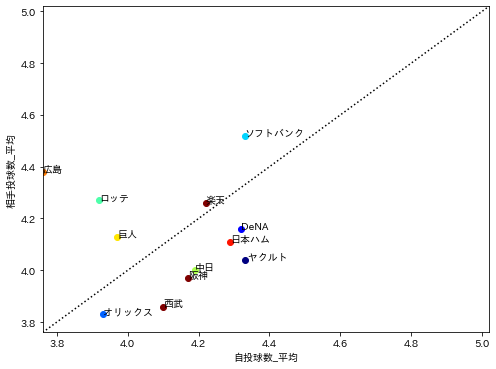

In [20]:
merged_df = check_merged_data(pitcher_df, "投球数", "count")
merged_df = merged_df.rename(columns = {"自投球数_": "自登板投手数",  "相手投球数_": "相手登板投手数"})

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自投球数_平均").to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自投球数_平均").to_markdown())

make_plot(merged_df)

### 投球数

,チーム,試合数,自投球数_合計,自投球数_平均,相手投球数_合計,相手投球数_平均
0,ヤクルト,27,3904,144.59,3921,145.22
1,DeNA,25,3628,145.12,3552,142.08
2,オリックス,29,4269,147.21,4004,138.07
3,ソフトバンク,27,3964,146.81,4147,153.59
4,ロッテ,26,3837,147.58,3874,149.00
5,中日,26,3774,145.15,3702,142.38
6,巨人,31,4563,147.19,4511,145.52
7,広島,29,4184,144.28,4366,150.55
8,日本ハム,28,4110,146.79,4001,142.89
9,楽天,23,3310,143.91,3568,155.13


|    | チーム       |   試合数 |   自投球数_合計 |   自投球数_平均 |
|---:|:-------------|---------:|----------------:|----------------:|
|  2 | オリックス   |       29 |            4269 |          147.21 |
|  3 | ソフトバンク |       27 |            3964 |          146.81 |
|  4 | ロッテ       |       26 |            3837 |          147.58 |
|  8 | 日本ハム     |       28 |            4110 |          146.79 |
|  9 | 楽天         |       23 |            3310 |          143.91 |
| 10 | 西武         |       29 |            4098 |          141.31 |
 
|    | チーム   |   試合数 |   自投球数_合計 |   自投球数_平均 |
|---:|:---------|---------:|----------------:|----------------:|
|  0 | ヤクルト |       27 |            3904 |          144.59 |
|  1 | DeNA     |       25 |            3628 |          145.12 |
|  5 | 中日     |       26 |            3774 |          145.15 |
|  6 | 巨人     |       31 |            4563 |          147.19 |
|  7 | 広島     |       29 |            4184 |          144.28 |
| 11 | 阪神     |       30 |            4260 |          142  

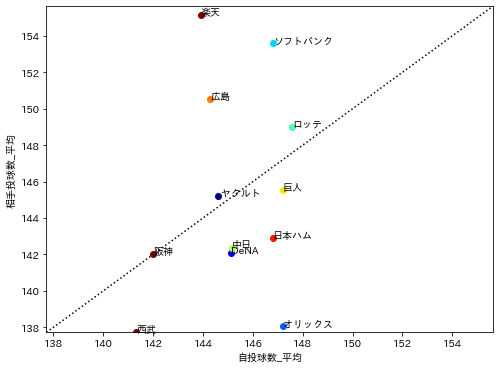

In [21]:
merged_df = check_merged_data(pitcher_df, "投球数", "sum")

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].to_markdown())

make_plot(merged_df)

In [22]:
pitch_num = pitcher_df.groupby("選手名").agg({"投球数": "sum", "自": "unique", "位": "unique", "ID": "count"}).reset_index()
pitch_num["自"] = pitch_num["自"].apply(lambda x: x[0])
pitch_num = pitch_num[~pitch_num["自"].isin(pacific)].sort_values("投球数", ascending=False).reset_index(drop=True)
pitch_num["flg"] = pitch_num["位"].apply(lambda x: "先発" in x and "中継" not in x)
print(pitch_num[pitch_num.flg].head(10).drop(["位", "flg"], axis=1).to_markdown())

|    | 選手名      |   投球数 | 自   |   ID |
|---:|:------------|---------:|:-----|-----:|
|  0 | ロメロ      |      727 | DeNA |    9 |
|  1 | 大瀬良 大地 |      685 | 広島 |    6 |
|  2 | 森下 暢仁   |      610 | 広島 |    6 |
|  3 | 菅野 智之   |      575 | 巨人 |    6 |
|  4 | 九里 亜蓮   |      552 | 広島 |    5 |
|  5 | 戸郷 翔征   |      548 | 巨人 |    5 |
|  6 | 大野 雄大   |      499 | 中日 |    5 |
|  7 | 柳 裕也     |      495 | 中日 |    4 |
|  8 | 西 勇輝     |      493 | 阪神 |    5 |
|  9 | メルセデス  |      485 | 巨人 |    5 |


In [160]:
pitch_num = pitcher_df.groupby("選手名").agg({"投球数": "sum", "自": "unique", "位": "unique", "ID": "count"}).reset_index()
pitch_num["自"] = pitch_num["自"].apply(lambda x: x[0])
pitch_num = pitch_num[~pitch_num["自"].isin(pacific)].sort_values("投球数", ascending=False).reset_index(drop=True)
pitch_num["flg"] = pitch_num["位"].apply(lambda x: "中継" in x and "先発" not in x)
print(pitch_num[pitch_num.flg].head(10).drop(["位", "flg"], axis=1).to_markdown())

|    | 選手名      |   投球数 | 自       |   ID |
|---:|:------------|---------:|:---------|-----:|
| 33 | 大下 佑馬   |      240 | ヤクルト |   10 |
| 38 | 畠 世周     |      214 | 巨人     |   13 |
| 39 | 大勢        |      205 | 巨人     |   13 |
| 40 | 中﨑 翔太   |      204 | 広島     |   13 |
| 41 | 木澤 尚文   |      202 | ヤクルト |    8 |
| 43 | 田中 健二朗 |      192 | DeNA     |   10 |
| 44 | 湯浅 京己   |      187 | 阪神     |   13 |
| 47 | エスコバー  |      177 | DeNA     |   11 |
| 48 | 黒原 拓未   |      175 | 広島     |   11 |
| 49 | 梅野 雄吾   |      170 | ヤクルト |   11 |


In [161]:
pitch_num = pitcher_df.groupby("選手名").agg({"投球数": "sum", "自": "unique", "位": "unique", "ID": "count"}).reset_index()
pitch_num["自"] = pitch_num["自"].apply(lambda x: x[0])
pitch_num = pitch_num[pitch_num["自"].isin(pacific)].sort_values("投球数", ascending=False).reset_index(drop=True)
pitch_num["flg"] = pitch_num["位"].apply(lambda x: "中継" in x and "先発" not in x)
print(pitch_num[pitch_num.flg].head(10).drop(["位", "flg"], axis=1).to_markdown())

|    | 選手名    |   投球数 | 自           |   ID |
|---:|:----------|---------:|:-------------|-----:|
| 32 | 宮川 哲   |      213 | 西武         |   11 |
| 33 | ビドル    |      200 | オリックス   |   13 |
| 34 | 藤井 皓哉 |      199 | ソフトバンク |   10 |
| 35 | 安樂 智大 |      193 | 楽天         |   12 |
| 37 | 松井 裕樹 |      192 | 楽天         |   12 |
| 39 | 西村 天裕 |      191 | 日本ハム     |    8 |
| 40 | 宮西 尚生 |      190 | 日本ハム     |   10 |
| 42 | 益田 直也 |      187 | ロッテ       |   10 |
| 43 | 平井 克典 |      184 | 西武         |   12 |
| 45 | 平良 海馬 |      175 | 西武         |   12 |


### 奪三振数

,チーム,試合数,自奪三振_合計,自奪三振_平均,相手奪三振_合計,相手奪三振_平均
0,ヤクルト,26,181,6.96,212,8.15
1,DeNA,24,173,7.21,160,6.67
2,オリックス,27,224,8.30,171,6.33
3,ソフトバンク,26,210,8.08,184,7.08
4,ロッテ,25,187,7.48,201,8.04
5,中日,24,169,7.04,157,6.54
6,巨人,29,199,6.86,193,6.66
7,広島,27,174,6.44,167,6.19
8,日本ハム,27,186,6.89,234,8.67
9,楽天,22,162,7.36,161,7.32


|    | チーム       |   試合数 |   自奪三振_合計 |   自奪三振_平均 |
|---:|:-------------|---------:|----------------:|----------------:|
| 10 | 西武         |       27 |             174 |            6.44 |
|  8 | 日本ハム     |       27 |             186 |            6.89 |
|  9 | 楽天         |       22 |             162 |            7.36 |
|  4 | ロッテ       |       25 |             187 |            7.48 |
|  3 | ソフトバンク |       26 |             210 |            8.08 |
|  2 | オリックス   |       27 |             224 |            8.3  |
 
|    | チーム   |   試合数 |   自奪三振_合計 |   自奪三振_平均 |
|---:|:---------|---------:|----------------:|----------------:|
|  7 | 広島     |       27 |             174 |            6.44 |
|  6 | 巨人     |       29 |             199 |            6.86 |
|  0 | ヤクルト |       26 |             181 |            6.96 |
|  5 | 中日     |       24 |             169 |            7.04 |
|  1 | DeNA     |       24 |             173 |            7.21 |
| 11 | 阪神     |       28 |             206 |            7.3

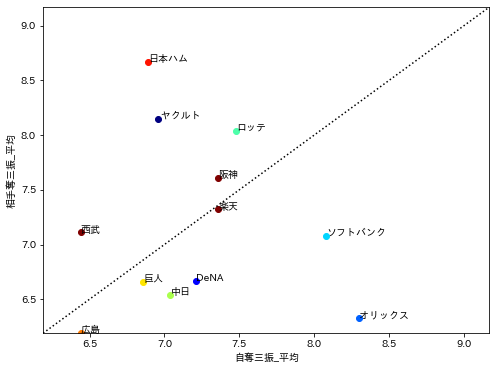

In [86]:
merged_df = check_merged_data(pitcher_df, "奪三振", "sum")

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自奪三振_平均").to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自奪三振_平均").to_markdown())

make_plot(merged_df)

### 対戦打者数

,チーム,試合数,自対戦打者_合計,自打者_平均,相手対戦打者_合計,相手打者_平均
0,ヤクルト,26,987,37.96,960,36.92
1,DeNA,24,913,38.04,893,37.21
2,オリックス,27,1003,37.15,982,36.37
3,ソフトバンク,26,962,37.00,999,38.42
4,ロッテ,25,929,37.16,943,37.72
5,中日,24,883,36.79,912,38.00
6,巨人,29,1063,36.66,1086,37.45
7,広島,27,1020,37.78,1030,38.15
8,日本ハム,27,1012,37.48,974,36.07
9,楽天,22,804,36.55,848,38.55


|    | チーム       |   試合数 |   自対戦打者_合計 |   自打者_平均 |
|---:|:-------------|---------:|------------------:|--------------:|
| 10 | 西武         |       27 |               979 |         36.26 |
|  9 | 楽天         |       22 |               804 |         36.55 |
|  3 | ソフトバンク |       26 |               962 |         37    |
|  2 | オリックス   |       27 |              1003 |         37.15 |
|  4 | ロッテ       |       25 |               929 |         37.16 |
|  8 | 日本ハム     |       27 |              1012 |         37.48 |
 
|    | チーム   |   試合数 |   自対戦打者_合計 |   自打者_平均 |
|---:|:---------|---------:|------------------:|--------------:|
|  6 | 巨人     |       29 |              1063 |         36.66 |
|  5 | 中日     |       24 |               883 |         36.79 |
| 11 | 阪神     |       28 |              1032 |         36.86 |
|  7 | 広島     |       27 |              1020 |         37.78 |
|  0 | ヤクルト |       26 |               987 |         37.96 |
|  1 | DeNA     |       24 |               913 |         38.0

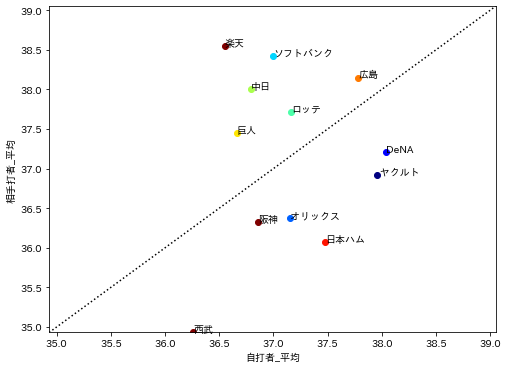

In [88]:
merged_df = check_merged_data(pitcher_df, "打者", "sum")
merged_df = merged_df.rename(columns = {"自打者_合計": "自対戦打者_合計", "相手打者_合計": "相手対戦打者_合計"})

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自打者_平均").to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自打者_平均").to_markdown())

make_plot(merged_df)

### 被本塁打数

,チーム,試合数,自被本塁打_合計,自被本塁打_平均,相手被本塁打_合計,相手被本塁打_平均
0,ヤクルト,26,27,1.04,26,1.00
1,DeNA,24,17,0.71,18,0.75
2,オリックス,27,18,0.67,8,0.30
3,ソフトバンク,26,24,0.92,16,0.62
4,ロッテ,25,9,0.36,8,0.32
5,中日,24,16,0.67,17,0.71
6,巨人,29,20,0.69,33,1.14
7,広島,27,21,0.78,9,0.33
8,日本ハム,27,16,0.59,25,0.93
9,楽天,22,13,0.59,18,0.82


|    | チーム       |   試合数 |   自被本塁打_合計 |   自被本塁打_平均 |
|---:|:-------------|---------:|------------------:|------------------:|
|  4 | ロッテ       |       25 |                 9 |              0.36 |
| 10 | 西武         |       27 |                13 |              0.48 |
|  8 | 日本ハム     |       27 |                16 |              0.59 |
|  9 | 楽天         |       22 |                13 |              0.59 |
|  2 | オリックス   |       27 |                18 |              0.67 |
|  3 | ソフトバンク |       26 |                24 |              0.92 |
 
|    | チーム   |   試合数 |   自被本塁打_合計 |   自被本塁打_平均 |
|---:|:---------|---------:|------------------:|------------------:|
|  5 | 中日     |       24 |                16 |              0.67 |
|  6 | 巨人     |       29 |                20 |              0.69 |
|  1 | DeNA     |       24 |                17 |              0.71 |
|  7 | 広島     |       27 |                21 |              0.78 |
| 11 | 阪神     |       28 |                22 |              0.79 |
|

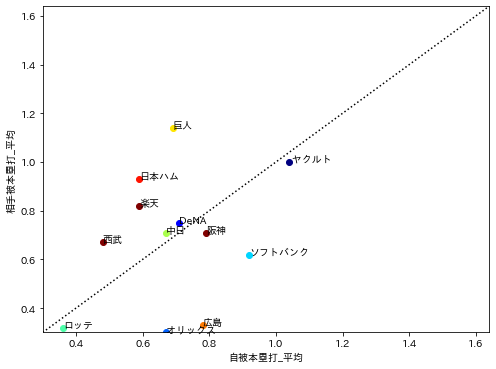

In [90]:
merged_df = check_merged_data(pitcher_df, "被本塁打", "sum")

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自被本塁打_平均").to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自被本塁打_平均").to_markdown())

make_plot(merged_df)

### 与四球

,チーム,試合数,自与四球_合計,自与四球_平均,相手与四球_合計,相手与四球_平均
0,ヤクルト,26,72,2.77,81,3.12
1,DeNA,24,71,2.96,60,2.50
2,オリックス,27,72,2.67,86,3.19
3,ソフトバンク,26,90,3.46,89,3.42
4,ロッテ,25,73,2.92,72,2.88
5,中日,24,54,2.25,63,2.62
6,巨人,29,88,3.03,95,3.28
7,広島,27,70,2.59,74,2.74
8,日本ハム,27,86,3.19,59,2.19
9,楽天,22,50,2.27,93,4.23


|    | チーム       |   試合数 |   自与四球_合計 |   自与四球_平均 |
|---:|:-------------|---------:|----------------:|----------------:|
|  9 | 楽天         |       22 |              50 |            2.27 |
|  2 | オリックス   |       27 |              72 |            2.67 |
|  4 | ロッテ       |       25 |              73 |            2.92 |
|  8 | 日本ハム     |       27 |              86 |            3.19 |
| 10 | 西武         |       27 |              91 |            3.37 |
|  3 | ソフトバンク |       26 |              90 |            3.46 |
 
|    | チーム   |   試合数 |   自与四球_合計 |   自与四球_平均 |
|---:|:---------|---------:|----------------:|----------------:|
|  5 | 中日     |       24 |              54 |            2.25 |
|  7 | 広島     |       27 |              70 |            2.59 |
| 11 | 阪神     |       28 |              76 |            2.71 |
|  0 | ヤクルト |       26 |              72 |            2.77 |
|  1 | DeNA     |       24 |              71 |            2.96 |
|  6 | 巨人     |       29 |              88 |            3.0

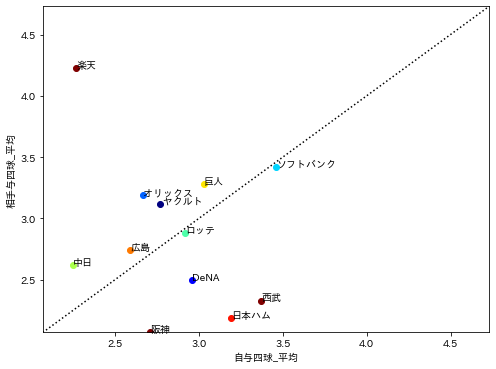

In [91]:
merged_df = check_merged_data(pitcher_df, "与四球", "sum")

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自与四球_平均").to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自与四球_平均").to_markdown())

make_plot(merged_df)

### 先発投球イニング

,チーム,試合数,自投球回_合計,自投球回_平均,相手投球回_合計,相手投球回_平均
0,ヤクルト,26,139.6,5.37,156.6,6.02
1,DeNA,24,129.3,5.39,140.8,5.87
2,オリックス,27,162.3,6.01,163.1,6.04
3,ソフトバンク,26,139.2,5.35,134.7,5.18
4,ロッテ,25,163.6,6.54,151.3,6.05
5,中日,24,142.6,5.94,136.4,5.68
6,巨人,29,170.3,5.87,159.9,5.51
7,広島,27,167.8,6.21,147.9,5.48
8,日本ハム,27,135.0,5.00,149.9,5.55
9,楽天,22,137.2,6.24,119.8,5.45


|    | チーム       |   試合数 |   自投球回_合計 |   自投球回_平均 |
|---:|:-------------|---------:|----------------:|----------------:|
|  8 | 日本ハム     |       27 |           135   |            5    |
| 10 | 西武         |       27 |           143.2 |            5.3  |
|  3 | ソフトバンク |       26 |           139.2 |            5.35 |
|  2 | オリックス   |       27 |           162.3 |            6.01 |
|  9 | 楽天         |       22 |           137.2 |            6.24 |
|  4 | ロッテ       |       25 |           163.6 |            6.54 |
 
|    | チーム   |   試合数 |   自投球回_合計 |   自投球回_平均 |
|---:|:---------|---------:|----------------:|----------------:|
|  0 | ヤクルト |       26 |           139.6 |            5.37 |
|  1 | DeNA     |       24 |           129.3 |            5.39 |
| 11 | 阪神     |       28 |           156.2 |            5.58 |
|  6 | 巨人     |       29 |           170.3 |            5.87 |
|  5 | 中日     |       24 |           142.6 |            5.94 |
|  7 | 広島     |       27 |           167.8 |            6.2

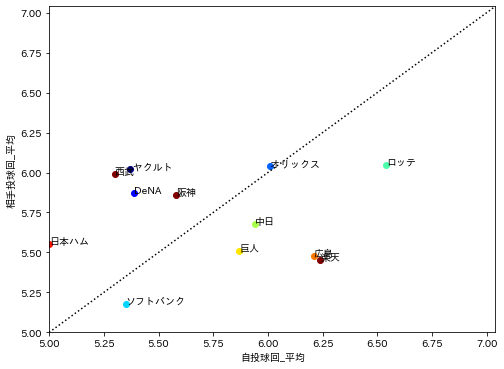

In [92]:
merged_df = check_merged_data(pitcher_df[pitcher_df["位"]=="先発"], "投球回", "sum")

display(merged_df)

print(merged_df[merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自投球回_平均").to_markdown())
print(" ")
print(merged_df[~merged_df["チーム"].isin(pacific)].iloc[:,:4].sort_values("自投球回_平均").to_markdown())

make_plot(merged_df)

## 被打率

In [116]:
hidaritu = batter_df.groupby(["相"]).agg({"打数": "sum", "安打": "sum"}).reset_index()
hidaritu["被打率"] = hidaritu["安打"] / hidaritu["打数"]
display(hidaritu)

print(hidaritu[hidaritu["相"].isin(pacific)].iloc[:,:4].sort_values("被打率", ascending=False).to_markdown())
print(" ")
print(hidaritu[~hidaritu["相"].isin(pacific)].iloc[:,:4].sort_values("被打率", ascending=False).to_markdown())

,相,打数,安打,被打率
0,ヤクルト,883,222,0.251416
1,DeNA,803,207,0.257783
2,オリックス,895,211,0.235754
3,ソフトバンク,846,181,0.213948
4,ロッテ,823,172,0.208991
5,中日,801,193,0.240949
6,巨人,939,213,0.226837
7,広島,924,226,0.244589
8,日本ハム,891,223,0.250281
9,楽天,732,161,0.219945


|    | 相           |   打数 |   安打 |   被打率 |
|---:|:-------------|-------:|-------:|---------:|
|  8 | 日本ハム     |    891 |    223 | 0.250281 |
|  2 | オリックス   |    895 |    211 | 0.235754 |
|  9 | 楽天         |    732 |    161 | 0.219945 |
| 10 | 西武         |    853 |    186 | 0.218054 |
|  3 | ソフトバンク |    846 |    181 | 0.213948 |
|  4 | ロッテ       |    823 |    172 | 0.208991 |
 
|    | 相       |   打数 |   安打 |   被打率 |
|---:|:---------|-------:|-------:|---------:|
|  1 | DeNA     |    803 |    207 | 0.257783 |
| 11 | 阪神     |    925 |    233 | 0.251892 |
|  0 | ヤクルト |    883 |    222 | 0.251416 |
|  7 | 広島     |    924 |    226 | 0.244589 |
|  5 | 中日     |    801 |    193 | 0.240949 |
|  6 | 巨人     |    939 |    213 | 0.226837 |


# 一球ごと

In [113]:
# 盗塁成功率, 阻止率を見る
result_columns = [i for i in detail_df.columns if "result_" in i]
type_columns = [i for i in detail_df.columns if "type_" in i]

# https://stackoverflow.com/questions/34045837/pandas-count-over-multiple-columns
count = pd.Series(detail_df[result_columns].squeeze().values.ravel()).value_counts()
count = pd.DataFrame({'Measure': count.index, 'Count':count.values})
count["Measure"].appply

0

# 改善案

- テキスト情報も取得する